# InternViT Classifier - threshold selection

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from epsutils.training.performance_curve_calculator import PerformanceCurveCalculator, PerformanceCurveType

ROOT_JSONL_DIR = "/home/arjun/tmp/classifier_val_data_08272025"
TARGET_PRECISION = 0.90

In [2]:
# Find all jsonl files in the root directory.
jsonl_files = []
for fname in os.listdir(ROOT_JSONL_DIR):
    if fname.endswith('.jsonl'):
        jsonl_files.append(fname.split(".")[0])

print("Num labels:", len(jsonl_files))

Num labels: 360


In [3]:
output_map = {}
threshold_info = []
for jsonl_file in jsonl_files:

    # Get body part and label from the jsonl file name.
    split = jsonl_file.split("release_intern_vit_classifier-training-on-")[1].split("_")
    body_part = split[0]
    label = "_".join(split[1:])

    # Create a new entry in the output map for the body part if it doesn't exist.
    if body_part not in output_map:
        output_map[body_part] = {}

    data = []
    fp = os.path.join(ROOT_JSONL_DIR, f"{jsonl_file}.jsonl")
    with open(fp, "r") as f:
        for line in f:
            data.append(json.loads(line))

    # Get predictions and labels.
    y_true = [int(d["target"][0]) for d in data]
    y_pred = [float(d["prob"]) for d in data]
    assert len(y_true) == len(y_pred)

    # Calculate the PR curve points.
    curve_calculator = PerformanceCurveCalculator()
    curve_data = curve_calculator.compute_curve(
        PerformanceCurveType.PRC, y_true, y_pred
    )
    precision = curve_data["precision"]
    recall = curve_data["recall"]
    thresholds = curve_data["thresholds"]

    # Find the threshold that gives the target precision.
    idx = np.argmax(precision >= TARGET_PRECISION)
    if idx == len(precision) - 1:
        idx = len(thresholds) // 2
        print(
            f"No threshold found for {body_part} - {label} at precision={TARGET_PRECISION}. Using the middle threshold (t={thresholds[len(precision) // 2]})."
        )

    # Store threshold info.
    threshold_info.append(
        {
            "body_part": body_part,
            "label": label,
            "threshold": float(thresholds[idx]),
            "precision": float(precision[idx]),
            "recall": float(recall[idx]),
        }
    )
    output_map[body_part][label] = float(thresholds[idx])

No threshold found for l-spine - spina_bifida_occulta at precision=0.9. Using the middle threshold (t=0.21484375).
No threshold found for head - hypoplastic_sinus at precision=0.9. Using the middle threshold (t=0.20703125).
No threshold found for head - abnormal_calcifications at precision=0.9. Using the middle threshold (t=0.2060546875).
No threshold found for l-spine - lumbarization_of_s1 at precision=0.9. Using the middle threshold (t=0.248046875).
No threshold found for pelvis - sacralization_of_spine at precision=0.9. Using the middle threshold (t=0.2421875).
No threshold found for foot - accessory_ossicles at precision=0.9. Using the middle threshold (t=0.25390625).
No threshold found for abdomen - masses at precision=0.9. Using the middle threshold (t=0.19921875).
No threshold found for leg - patellar_tracking_abnormalities at precision=0.9. Using the middle threshold (t=0.2041015625).
No threshold found for c-spine - lateral_curvature at precision=0.9. Using the middle threshol

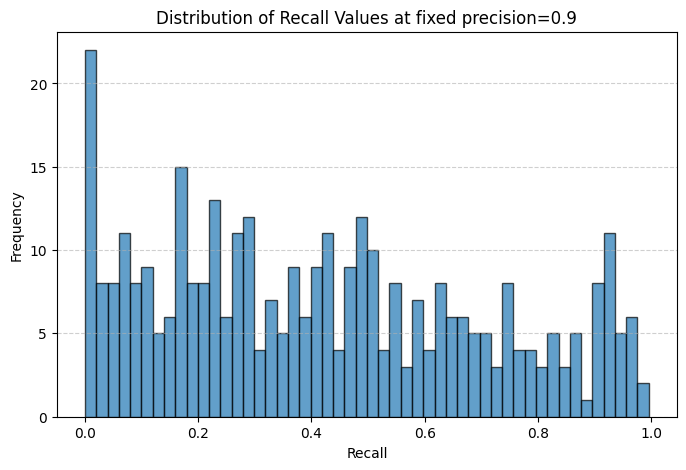

Recall Statistics at fixed precision=0.90:
  Mean recall:    0.4190
  Median recall:  0.3914
  Min recall:     0.0004
  Max recall:     0.9952
  Std deviation:  0.2844
  % >= 0.99:      0.3%
  % >= 0.95:      2.8%
  % >= 0.90:      8.1%
  % >= 0.80:      13.6%


In [4]:

recalls = [t["recall"] for t in threshold_info]
plt.figure(figsize=(8, 5))
plt.hist(recalls, bins=50, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Recall Values at fixed precision={TARGET_PRECISION}')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

import numpy as np

# Calculate useful statistics for recall values
recalls_np = np.array(recalls)
mean_recall = np.mean(recalls_np)
median_recall = np.median(recalls_np)
min_recall = np.min(recalls_np)
max_recall = np.max(recalls_np)
std_recall = np.std(recalls_np)
percent_above_99 = np.mean(recalls_np >= 0.99) * 100
percent_above_95 = np.mean(recalls_np >= 0.95) * 100
percent_above_90 = np.mean(recalls_np >= 0.90) * 100
percent_above_80 = np.mean(recalls_np >= 0.80) * 100

print("Recall Statistics at fixed precision={:.2f}:".format(TARGET_PRECISION))
print(f"  Mean recall:    {mean_recall:.4f}")
print(f"  Median recall:  {median_recall:.4f}")
print(f"  Min recall:     {min_recall:.4f}")
print(f"  Max recall:     {max_recall:.4f}")
print(f"  Std deviation:  {std_recall:.4f}")
print(f"  % >= 0.99:      {percent_above_99:.1f}%")
print(f"  % >= 0.95:      {percent_above_95:.1f}%")
print(f"  % >= 0.90:      {percent_above_90:.1f}%")
print(f"  % >= 0.80:      {percent_above_80:.1f}%")

In [5]:
# Write the thresholds to a json file for ingestion by production inference code.
output_fp = "/home/arjun/tmp/classifier_thresholds_by_label.json"
with open(output_fp, "w") as f:
    json.dump(output_map, f, indent=2)
print(f"Thresholds written to {output_fp}")

Thresholds written to /home/arjun/tmp/classifier_thresholds_by_label.json


In [7]:
for t in threshold_info:
    body_part = t.get("body_part", "N/A")
    label = t.get("label", "N/A")
    threshold = t.get("threshold", "N/A")
    precision = t.get("precision", "N/A")
    recall = t.get("recall", "N/A")
    print(f"Body part: {body_part}, Label: {label}")
    print(f"  Threshold: {threshold}")
    print(f"  Precision: {precision}")
    print(f"  Recall:    {recall}")
    print("")


Body part: arm, Label: fracture
  Threshold: 0.4609375
  Precision: 0.9001213101496158
  Recall:    0.6514105115299075

Body part: hand, Label: tendon_avulsion_fractures
  Threshold: 0.71875
  Precision: 0.9064748201438849
  Recall:    0.1728395061728395

Body part: c-spine, Label: fracture
  Threshold: 0.75390625
  Precision: 0.9019607843137255
  Recall:    0.11288343558282209

Body part: l-spine, Label: support_devices
  Threshold: 0.388671875
  Precision: 0.9004642936104356
  Recall:    0.7348441108545035

Body part: abdomen, Label: diaphragmatic_hernia
  Threshold: 0.515625
  Precision: 0.9111111111111111
  Recall:    0.25625

Body part: abdomen, Label: no_findings
  Threshold: 0.75
  Precision: 0.9015317286652079
  Recall:    0.0938496583143508

Body part: hand, Label: ulnar_variance
  Threshold: 0.7265625
  Precision: 0.9014084507042254
  Recall:    0.0350109409190372

Body part: chest, Label: enlarged_pulmonary_artery
  Threshold: 0.45703125
  Precision: 0.9039408866995073
  Rec